In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
df = pd.read_csv('clinvar_conflicting.csv')
df.info()

/Users/chockalingam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
CHROM                 65188 non-null object
POS                   65188 non-null int64
REF                   65188 non-null object
ALT                   65188 non-null object
AF_ESP                65188 non-null float64
AF_EXAC               65188 non-null float64
AF_TGP                65188 non-null float64
CLNDISDB              65188 non-null object
CLNDISDBINCL          76 non-null object
CLNDN                 65188 non-null object
CLNDNINCL             76 non-null object
CLNHGVS               65188 non-null object
CLNSIGINCL            76 non-null object
CLNVC                 65188 non-null object
CLNVI                 27659 non-null object
MC                    58219 non-null object
ORIGIN                59065 non-null float64
SSR                   104 non-null float64
CLASS                 65188 non-null int64
Allele                65188 non-null object
Consequence        

# Exploratory Data Analysis

The graph given below is heavily biased towards the non - conflicting genes and that too with the CHROM == 2 standing out as large sky scrapper.

Inference - genes are recorded to be conflicting, our classifiers won't work great job and we can assume that most of them would take CHROM 2 as their most important feature.

In [20]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


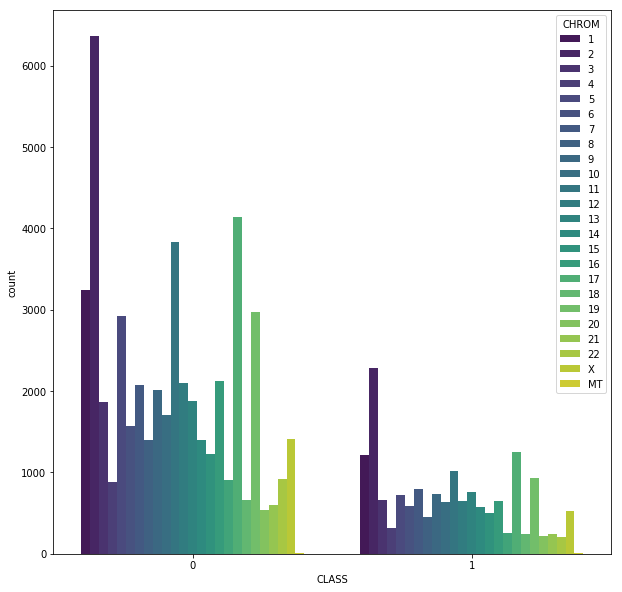

In [22]:
fig = plt.figure(figsize = (10, 10))
sns.countplot(x= 'CLASS', data = df, hue = 'CHROM', palette='viridis')

# Heatmap

As per the heatmap below, the yellow bands are the null values. They are not really worth estimating due to missing values in the data set.

We can simply try considering the ones with minimum losses and consider the features with <1000 unique features. Otherwise if it completely numerical data we can replave NaN value with mean value and proceed with analysis.

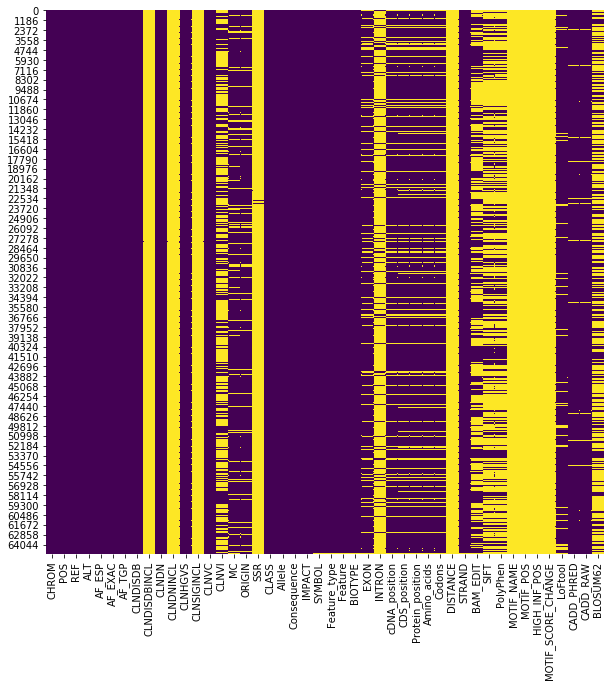

In [23]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = False)

We will take data which need to be considered in the data frame and arrive df2. Moreove will drop all null values in the df2 dataframe

In [24]:
toBeConsidered = ['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP',
       'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVC','MC', 'ORIGIN', 'CLASS',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type',
       'Feature', 'BIOTYPE', 'STRAND','CADD_PHRED', 'CADD_RAW']
df2 = df[toBeConsidered]
df2 = df2.dropna()

In [25]:
cutdowns = []
for i in df2.columns.values:
    if df2[i].nunique() < 1000:
        cutdowns.append(i)
print("The selected Columns for training are : ", cutdowns)

The selected Columns for training are :  ['CHROM', 'REF', 'ALT', 'CLNVC', 'MC', 'ORIGIN', 'CLASS', 'Allele', 'Consequence', 'IMPACT', 'Feature_type', 'BIOTYPE', 'STRAND']


In [26]:
df_final = df2[cutdowns]

In [27]:
df_final['CHROM'] = df_final['CHROM'].astype(str)

/Users/chockalingam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Deriving Feature

Applying Feature Hashers on the columns with > 10 unique values.

This class turns sequences of symbolic feature names (strings) into scipy.sparse matrices, using a hash function to compute the matrix column corresponding to a name.


In [28]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features = 5, input_type = 'string')
hashed1 = fh.fit_transform(df_final['REF'])
hashed1 = hashed1.toarray()
hashedFeatures1 = pd.DataFrame(hashed1)

In [29]:
nameList = {}
for i in hashedFeatures1.columns.values:
    nameList[i] = "REF"+str(i+1)


hashedFeatures1.rename(columns = nameList, inplace = True)
print("The Hashed REF table is somethinng like this : \n",hashedFeatures1.head())

The Hashed REF table is somethinng like this : 
    REF1  REF2  REF3  REF4  REF5
0   0.0   0.0   0.0   0.0   1.0
1   0.0   0.0   0.0   0.0   1.0
2   0.0   0.0   0.0   0.0   1.0
3   0.0  -1.0   0.0   0.0   0.0
4   0.0  -1.0   0.0   0.0   0.0


In [30]:
hashed2 = fh.fit_transform(df_final['ALT'])
hashed2 = hashed2.toarray()
hashedFeatures2 = pd.DataFrame(hashed2)

nameList2 = {}
for i in hashedFeatures2.columns.values:
    nameList2[i] = "ALT"+str(i+1)


hashedFeatures2.rename(columns = nameList2, inplace = True)
print("The Hashed ALT table is somethinng like this : \n",hashedFeatures2.head())

The Hashed ALT table is somethinng like this : 
    ALT1  ALT2  ALT3  ALT4  ALT5
0   0.0  -1.0   0.0   0.0   0.0
1   0.0  -1.0   0.0   0.0   0.0
2   0.0  -1.0   0.0   0.0   0.0
3   0.0  -1.0   0.0   0.0   0.0
4   0.0  -1.0   0.0   0.0   0.0


In [31]:
binaryFeature1 = pd.get_dummies(df_final['CLNVC'])
print("While the One hot encoded matrix of CLNVC Columns is like this : \n")
binaryFeature1.head()

While the One hot encoded matrix of CLNVC Columns is like this : 



,Deletion,Duplication,Indel,Insertion,Inversion,Microsatellite,single_nucleotide_variant
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [32]:
df_final = df_final.drop(columns=['MC'], axis = 1)

In [33]:
hashed0 = fh.fit_transform(df_final['CHROM'])
hashed0 = hashed0.toarray()
hashedFeatures0 = pd.DataFrame(hashed0)

nameList0 = {}
for i in hashedFeatures0.columns.values:
    nameList0[i] = "CHROM"+str(i+1)


hashedFeatures0.rename(columns = nameList0, inplace = True)
hashedFeatures0.head()

,CHROM1,CHROM2,CHROM3,CHROM4,CHROM5
0,0.0,0.0,-1.0,0.0,0.0
1,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,-1.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,0.0


In [34]:
hashed3 = fh.fit_transform(df_final['Allele'])
hashed3 = hashed3.toarray()
hashedFeatures3 = pd.DataFrame(hashed3)

nameList3 = {}
for i in hashedFeatures3.columns.values:
    nameList3[i] = "Allele"+str(i+1)


hashedFeatures3.rename(columns = nameList3, inplace = True)
hashedFeatures3.head()

,Allele1,Allele2,Allele3,Allele4,Allele5
0,0.0,-1.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0,0.0
2,0.0,-1.0,0.0,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0
4,0.0,-1.0,0.0,0.0,0.0


In [35]:
hashed4 = fh.fit_transform(df_final['Consequence'])
hashed4 = hashed4.toarray()
hashedFeatures4 = pd.DataFrame(hashed4)

nameList4 = {}
for i in hashedFeatures4.columns.values:
    nameList4[i] = "Consequence"+str(i+1)


hashedFeatures4.rename(columns = nameList4, inplace = True)
hashedFeatures4.head()

,Consequence1,Consequence2,Consequence3,Consequence4,Consequence5
0,3.0,-1.0,0.0,0.0,-4.0
1,3.0,0.0,1.0,2.0,-4.0
2,3.0,-1.0,0.0,0.0,-4.0
3,3.0,0.0,1.0,2.0,-4.0
4,3.0,0.0,1.0,2.0,-4.0


In [36]:
df_final['IMPACT'].nunique()

4

In [37]:
binaryFeature3 = pd.get_dummies(df_final['IMPACT'])
binaryFeature3.head()

,HIGH,LOW,MODERATE,MODIFIER
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


In [38]:
df_final = df_final.drop(columns=['Feature_type'], axis = 1)

In [39]:
binaryFeature4 = pd.get_dummies(df_final['BIOTYPE'], drop_first=True)
binaryFeature4.head()

,protein_coding
0,1
1,1
2,1
3,1
4,1


In [40]:
binaryFeature5 = pd.get_dummies(df_final['STRAND'], drop_first=True)
binaryFeature5.head()

,1.0
0,1
1,1
2,1
3,1
4,1


# Creating the final table

Storing the final values in the table df3 and you can see the new columns after Feature Engineering as follows

In [41]:
df3 = pd.concat([binaryFeature1, binaryFeature3, binaryFeature4, binaryFeature5, hashedFeatures1 , hashedFeatures2, hashedFeatures3, hashedFeatures4,hashedFeatures0, df_final['CLASS']], axis=1)
df3 = df3.dropna()
df3.rename(columns={1 : "one", 16 : "sixteen"}, inplace = True)
print(df3.columns.values)
df3.head()

['Deletion' 'Duplication' 'Indel' 'Insertion' 'Inversion' 'Microsatellite'
 'single_nucleotide_variant' 'HIGH' 'LOW' 'MODERATE' 'MODIFIER'
 'protein_coding' 'one' 'REF1' 'REF2' 'REF3' 'REF4' 'REF5' 'ALT1' 'ALT2'
 'ALT3' 'ALT4' 'ALT5' 'Allele1' 'Allele2' 'Allele3' 'Allele4' 'Allele5'
 'Consequence1' 'Consequence2' 'Consequence3' 'Consequence4'
 'Consequence5' 'CHROM1' 'CHROM2' 'CHROM3' 'CHROM4' 'CHROM5' 'CLASS']


,Deletion,Duplication,Indel,Insertion,Inversion,Microsatellite,single_nucleotide_variant,HIGH,LOW,MODERATE,...,Consequence2,Consequence3,Consequence4,Consequence5,CHROM1,CHROM2,CHROM3,CHROM4,CHROM5,CLASS
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.0,0.0,0.0,-4.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,-4.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.0,0.0,0.0,-4.0,0.0,0.0,-1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,-4.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,-4.0,0.0,0.0,-1.0,0.0,0.0,1.0


In [42]:
y = df3['CLASS']
X = df3.drop(columns=['CLASS'], axis = 1)

# Importing Machine Learning Libraries

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Logistic regression

In [50]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_lr))

Classification Report :
               precision    recall  f1-score   support

        0.0       0.75      1.00      0.86      9451
        1.0       0.00      0.00      0.00      3176

avg / total       0.56      0.75      0.64     12627



/Users/chockalingam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The above regression method provides only 56% of accuracy in terms of total precision. Also it is not providing the necessary result of conflicting genes.

# Decision Trees

In [52]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_dt))

Classification Report :
               precision    recall  f1-score   support

        0.0       0.75      1.00      0.86      9451
        1.0       0.00      0.00      0.00      3176

avg / total       0.56      0.75      0.64     12627



Even Decision tree produce the same result

# Random Forest

In [53]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print( "Classification Report :\n ", classification_report(y_test, pred_rf))

Classification Report :
               precision    recall  f1-score   support

        0.0       0.75      0.95      0.84      9451
        1.0       0.30      0.06      0.10      3176

avg / total       0.64      0.73      0.65     12627



Random forest provide better results of 64% with improvement in Recall and F1 score of non conflicting genes and the Precision in conflicting Genes.

# Comparing feature Models

We should look at how Random Forest and Logistic regression, the best and the worst performers in this classification task came about ranking the importance of their given features!

In [55]:
from collections import OrderedDict

# Inference - Logistic Regression

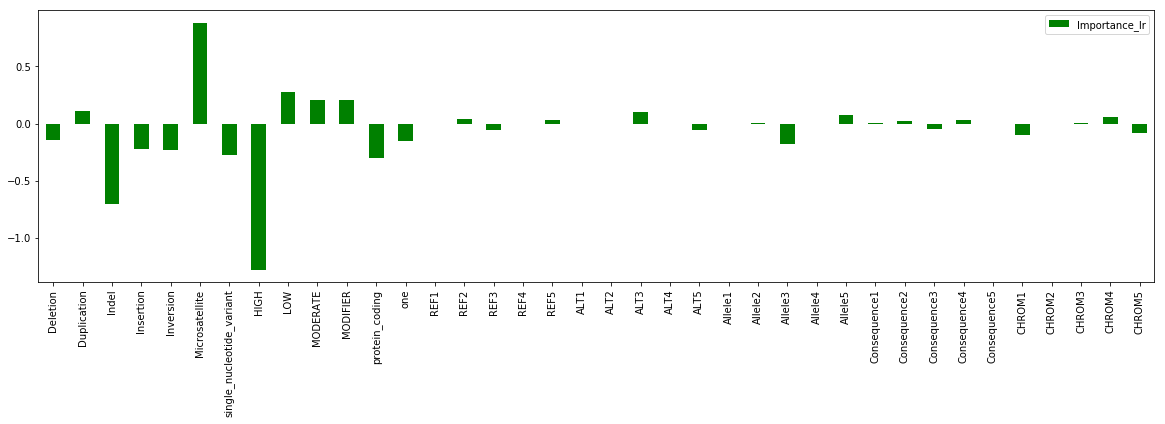

In [56]:
feature_imp = {}
for i in zip(X.columns, lr.coef_[0]):
    feature_imp[i[0]] = i[1]
final_imp = OrderedDict(feature_imp)
df_features = pd.DataFrame(final_imp, index = range(1)).T
df_features.rename(columns={0: "Importance_lr"}, inplace = True)

my_colors = ['g', 'b']*5

df_features.plot(kind='bar',figsize = (20,5), color = my_colors)

From the graph, we can easily understand that the most important features taken into consideration by Logistic Regressor are Inversion, Microsatellite and LOW, while the chromosomes are given very little or no importance

# Inference - Random Forest classifier

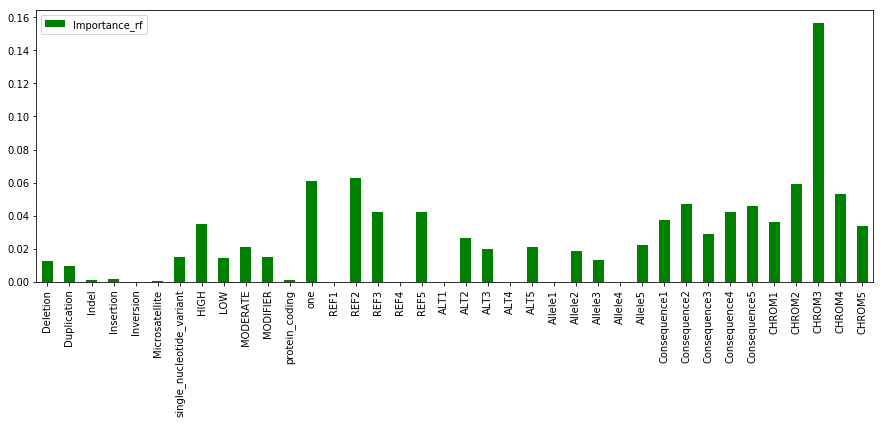

In [57]:
feature_imp2 = {}
for i in zip(X.columns, rf.feature_importances_):
    feature_imp2[i[0]] = i[1]

final_imp2 = OrderedDict(feature_imp2)
#print(feature_imp2)
df_features2 = pd.DataFrame(final_imp2, index = range(1)).T
df_features2.rename(columns={0: "Importance_rf"}, inplace = True)
df_features2.plot(kind='bar',figsize = (15, 5), color = my_colors)

We can easily see that the feature importance is way different for Random forest classifier which focusses primely on Chromosomes (CHROM) Hashes

# Side by Side comparison

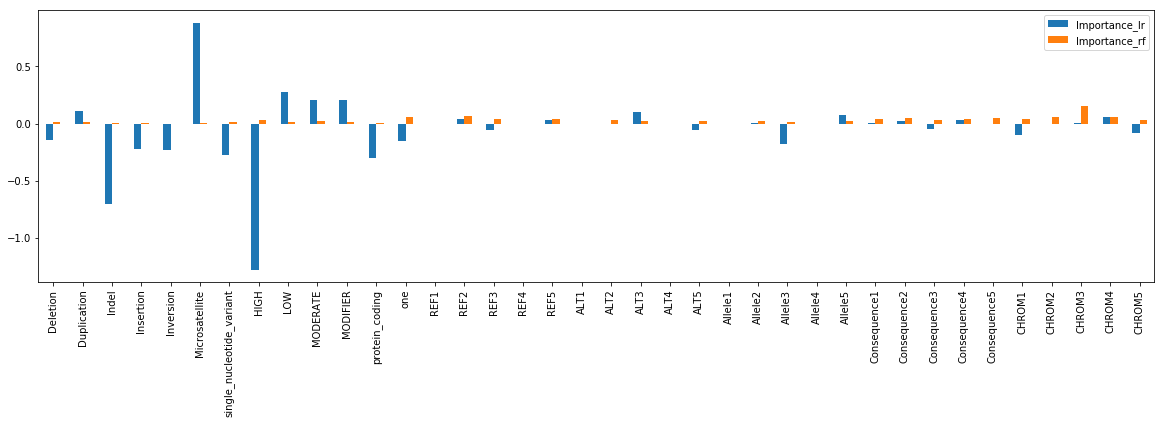

In [58]:
df_compare = pd.concat([df_features, df_features2], axis = 1)
df_compare.plot(kind='bar',figsize = (20, 5))

# Conclusion

By this, we can conclude that Random Forest Classifier is our best bet.